In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from PIL import Image
import os
from torchinfo import summary

In [2]:
m = models.resnet50(pretrained=True)
summary(m, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"], 
        row_settings=["var_names"],
        # verbose=2
        )

c:\Users\me1kox\AppData\Local\miniconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\me1kox\AppData\Local\miniconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet (ResNet)                          [1, 3, 224, 224]          [1, 1000]                 --                        True
├─Conv2d (conv1)                         [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]         [1, 64, 112, 112]         128                       True
├─ReLU (relu)                            [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]         [1, 64, 56, 56]           --                        --
├─Sequential (layer1)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        True
│    └─Bottleneck (0)                    [1, 64, 56, 56]           [1, 256, 56, 56]          --                        True
│    │ 

In [3]:
train_nodes, eval_nodes = get_graph_node_names(m)
print(m)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

c:\Users\me1kox\AppData\Local\miniconda3\envs\pytorch_env\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\me1kox\AppData\Local\miniconda3\envs\pytorch_env\lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\me1kox\AppData\Local\miniconda3\envs\pytorch_env\lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\me1kox\AppData\Local\miniconda3\envs\pytorch_env\lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [4]:
return_nodes = {
    # node_name: user-specified key for output dict
    'layer1.2.relu_2': 'layer1_output',
    'layer2.3.relu_2': 'layer2_output',
    'layer3.5.relu_2': 'layer3_output',
    'layer4.2.relu_2': 'layer4_output',
}

feature_extractor = create_feature_extractor(m, return_nodes=return_nodes)

# test feature extraction
image = torch.rand(1, 3, 224, 224).to('cuda')
with torch.no_grad():
    features = feature_extractor(image)

for k, v in features.items():
    print(k, v.shape)


layer1_output torch.Size([1, 256, 56, 56])
layer2_output torch.Size([1, 512, 28, 28])
layer3_output torch.Size([1, 1024, 14, 14])
layer4_output torch.Size([1, 2048, 7, 7])


In [5]:
class PatchCore:
    def __init__(self, feature_extractor, neighbourhood_size, subsample_size, device='cuda'):
        self.feature_extractor = feature_extractor
        self.neighbourhood_size = neighbourhood_size
        self.subsample_size = subsample_size
        self.device = device
        self.memory_bank = None
        self.subsample_indices = None
        
    # def extract_patches(self, image):
    #     patches = image.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
    #     patches = patches.contiguous().view(-1, 3, self.patch_size, self.patch_size)
    #     return patches
    
    def neighbourhood_aggregation(self, features):
        pooling_layer = nn.AvgPool2d(kernel_size=self.neighbourhood_size, stride=1, padding=self.neighbourhood_size//2)
        output = pooling_layer(features)
        return output
        

    def extract_features(self, images):
        self.feature_extractor.eval()
        # features = []
        # covert list of images to batch
        images = torch.stack(images)
        with torch.no_grad():
            # patches = self.extract_patches(image)
            images = images.to(self.device)
            patch_features = self.feature_extractor(images)
            # features.append(patch_features.cpu().numpy())
        return patch_features
    
    def build_memory_bank(self, normal_images):
        normal_features = self.extract_features(normal_images)
        normal_features = self.neighbourhood_aggregation(normal_features)
        self.memory_bank = normal_features.view(normal_features.shape[0], -1).cpu().numpy()
        return self.memory_bank
    
    def initialize_subset(self):
        centroid = np.mean(self.memory_bank, axis=0)
        distances = euclidean_distances([centroid], self.memory_bank).flatten()
        farthest_point_index = np.argmax(distances)
        subset_indices = [farthest_point_index]
        return subset_indices
    
    def select_next_point(self, subset_indices):
        subset = self.memory_bank[subset_indices]
        distances_to_subset = euclidean_distances(self.memory_bank, subset)
        min_distances = np.min(distances_to_subset, axis=1)
        next_point_index = np.argmax(min_distances)
        return next_point_index
    
    def corset_subsampling(self):
        subset_indices = self.initialize_subset()
        while len(subset_indices) < self.subsample_size:
            next_point_index = self.select_next_point(subset_indices)
            subset_indices.append(next_point_index)
        self.subsample_indices = np.array(subset_indices)
    
    def detect_anomalies(self, test_images):
        # test_features = self.extract_features(test_images).view(len(test_images), -1).cpu().numpy()
        test_features = self.extract_features(test_images)
        test_features = self.neighbourhood_aggregation(test_features).cpu().numpy()
        subsampled_memory_bank = self.memory_bank[self.subsample_indices]
        
        reshaped_memory_bank = subsampled_memory_bank.reshape(subsampled_memory_bank.shape[0], test_features.shape[1], test_features.shape[2], test_features.shape[3])
        
        heatmap = np.zeros((test_features.shape[0],test_features.shape[2], test_features.shape[3]))
        for sample_idx in range(test_features.shape[0]):
            for i in range(test_features.shape[2]):
                for j in range(test_features.shape[3]):
                    tf = test_features[sample_idx, :, i, j]
                    ssmb = reshaped_memory_bank[:, :, i, j]
                    distances_to_memory_bank = euclidean_distances([tf], ssmb)
                    anomaly_score = np.min(distances_to_memory_bank, axis=1)
                    heatmap[sample_idx, i, j] = anomaly_score.item()
        
        # distances_to_memory_bank = euclidean_distances(test_features, subsampled_memory_bank)
        # anomaly_scores = np.min(distances_to_memory_bank, axis=1)
        return heatmap

# Define the feature extractor using a pre-trained ResNet model
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        resnet = models.resnet50(pretrained=True)
        return_nodes = {
            # node_name: user-specified key for output dict
            'layer1.2.relu_2': 'layer1_output',
            # 'layer2.3.relu_2': 'layer2_output',
            # 'layer3.5.relu_2': 'layer3_output',
            # 'layer4.2.relu_2': 'layer4_output',
            }

        self.features = create_feature_extractor(resnet, return_nodes=return_nodes)
        self.model_summary = summary(
            self.features, 
            input_size=(1, 3, 224, 224),
            col_names=["input_size", "output_size", "num_params", "trainable"], 
            row_settings=["var_names"],
            )
        
    def forward(self, x):
        with torch.no_grad():
            out = self.features(x)
            out = out['layer1_output']
            # out = out.view(out.size(0), -1) # flattens
        return out


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load pre-trained feature extractor
feature_extractor = FeatureExtractor().to(device)    

# Initialize PatchCore
patchcore = PatchCore(feature_extractor, neighbourhood_size=3, subsample_size=50, device=device)

# Load and preprocess images (for example purposes, use random noise as images)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
        ])

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(transform(img))
    return images

normal_images = load_images_from_folder(r'C:\Users\me1kox\Local scratch space\mvtec_anomaly_detection\wood\train\good')
patchcore.build_memory_bank(normal_images)   
patchcore.corset_subsampling()    


In [38]:
test_images = load_images_from_folder(r'C:\Users\me1kox\Local scratch space\mvtec_anomaly_detection\wood\test\good')
# test_images = load_images_from_folder(r'C:\Users\me1kox\Local scratch space\mvtec_anomaly_detection\wood\test\color')


# Detect anomalies in test images
anomaly_maps = patchcore.detect_anomalies(test_images)

print("Anomaly Scores:", anomaly_maps.shape)


Anomaly Scores: (19, 56, 56)


In [9]:
# test_images = load_images_from_folder(r'C:\Users\me1kox\Local scratch space\mvtec_anomaly_detection\wood\test\good')
test_images = load_images_from_folder(r'C:\Users\me1kox\Local scratch space\mvtec_anomaly_detection\wood\test\combined')


# Detect anomalies in test images
anomaly_maps = patchcore.detect_anomalies(test_images)

print("Anomaly Scores:", anomaly_maps.shape)


Anomaly Scores: (11, 56, 56)


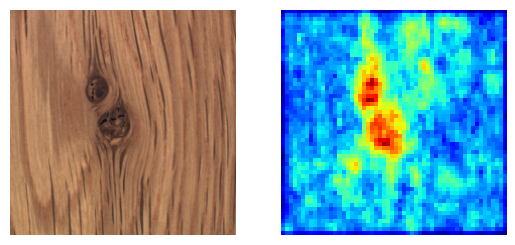

In [12]:
# display image and heatmap
idx= 4

import matplotlib.pyplot as plt
fig,axs = plt.subplots(1,2)
axs[0].imshow(test_images[idx].permute(1, 2, 0))
axs[1].imshow(anomaly_maps[idx], cmap='jet')
axs[0].axis('off')
axs[1].axis('off')
plt.show()
